In [1]:
%run init_notebook.py

In [2]:
# data: overall data
# df: data frame for one section
# sub: intermediary variable

In [3]:
from src.utils import load_pd_df, save_pd_df, pd_join_freq, pd_df_astype
from src.statsmodels import get_statsmodels_summary
from src.processing import pd_groupby
# from src.nlp_utils import evalute_optimal_smoothing
# from src.pymc_modelling import get_samp

In [4]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import scipy

In [5]:
def get_ols_dummies(df, drop_first: bool = True, drop_singular: bool = True):
    
    # nan warning
    assert df.isna().sum().sum() == 0, "data frame contains NaNs"
    
    for col in df.columns:
        
        if df[col].dtype == 'category':            
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=drop_first)
            filt = dummies.apply(lambda x: len(set(x)) > 1, axis=0)
            
            # check for singular values
            if filt.sum() != dummies.shape[1]:
                print(dummies.loc[:, ~filt].columns)
            if drop_singular:
                dummies = dummies.loc[:, filt]
                
            df = df.drop(col, axis=1).join(dummies)
            
    return df
def arr_starndardise(arr):
    return (arr - arr.mean()) / arr.std()

In [6]:
from statsmodels.regression.linear_model import OLS

# load data

In [7]:
hhp = load_pd_df('hhp_processed.feather', DATA_DIR)
pi = load_pd_df('pi.feather')
mir = pd_df_astype(load_pd_df('mir.csv').set_index('date'))

In [8]:
hhp['month_recorded'] = hhp.date_recorded.dt.to_period('M').dt.to_timestamp()
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

hhp['month_forecast'] = hhp.date_forecast.dt.to_period('M').dt.to_timestamp()
hhp['week_forecast'] = hhp.date_forecast.dt.to_period('W').dt.to_timestamp()

hhp['pi_delta_exp'] = hhp.pi_exp - hhp.pi_perc

## get grouped vars bayesian splines

In [9]:
# ser = hhp.set_index(['week_recorded', 'id']).pi_delta_exp.unstack().copy().mean(axis=1)
# ser.dropna().plot()

# %%capture
# # res = evalute_optimal_smoothing(ser, range(90, 300, 10))

# def get_post_sample(idata, mu_name: str = 'mu', n_samples: int = 100):
#     # number of chains
#     n_chains = len(idata.sample_stats.chain)
#     # number of draws in a chain
#     n_draws = len(idata.sample_stats.draw)
    
#     post = idata.posterior
#     # number of data observations
#     n_obs = post[mu_name].shape[2:]
    
#     # number of samples to draw from posterior
#     n_samples = min(n_samples, n_chains * n_draws)
    
#     samp = post[mu_name].values[:, get_samp(n_draws, 100),:].reshape(n_chains*100, *n_obs)
    
#     return samp

# dict_posts = {k: get_post_sample(res[2][k]) for k in res[2].keys()}
# df_post_means = pd.DataFrame({k: dict_posts[k].mean(axis=0) for k in dict_posts.keys()})

# plt.plot(
#     df_post_means @ (res[0].elpd_waic / res[0].elpd_waic.sum()),
#     label='mod'
# )
# plt.plot(df_post_means, color='grey', alpha=.2)
# plt.plot(ser.values, label='true')
# plt.legend()
# ;

# preprocess

In [10]:
# replace nan in hhp
dict_nans = {
    -9998: np.nan,
    -9997: np.nan,
}
for col in hhp:
    try:
        hhp[col] = hhp[col].astype(float).replace(dict_nans)
    except Exception as e:
        continue

In [11]:
# riskaversion is consistent across all respondents
## drop all non-riskaversion respondents

sub = hhp[~hhp.riskaversion.isna()].copy()
sub1 = sub.copy().groupby('id').riskaversion.agg(['mean', 'max'])
(sub1['mean'] == sub1['max']).min()

True

In [12]:
# merge riskaversion to all respodents, who have indicated it
_ = sub.groupby('id').riskaversion.last().rename('riskaversion')
hhp = hhp.drop('riskaversion', axis=1).set_index('id').join(_).copy().reset_index()

In [13]:
data = hhp.copy()

## merge pi

In [14]:
# merge pi at t+12
sub = pi[['pi_de_Y', 'pi_de']].rename(columns={'pi_de': 'pi_de_M'}).copy().dropna() #.shift(12)
sub['pi_de_Y_delta'] = sub.pi_de_Y.shift(12).values - sub.pi_de_Y.values
sub.columns = ['pi_de_Y_F', 'pi_de_M_F', 'pi_de_Y_delta_F']
sub = pi[['pi_de_Y', 'pi_de']].rename(columns={'pi_de': 'pi_de_M'}).copy().join(sub)
sub = sub.dropna()

data = data.set_index('month_recorded').join(sub).reset_index()

## get residuals

In [15]:
data['pi_perc_resid'] = data.pi_perc - data.pi_de_Y
data['pi_exp_resid'] = data.pi_exp - data.pi_de_Y_F
data['pi_delta_exp_resid'] = data.pi_delta_exp - data.pi_de_Y_delta_F

In [16]:
for col in ['pi_delta_exp_resid', 'pi_delta_exp']:
    data = data.set_index('week_recorded').join(
        pd_groupby(data.set_index('date_recorded'), [col], 'W', 'mean').iloc[:,0].rename(f'{col}_W')
    ).reset_index(names='week_recorded')

<AxesSubplot: xlabel='week_recorded'>

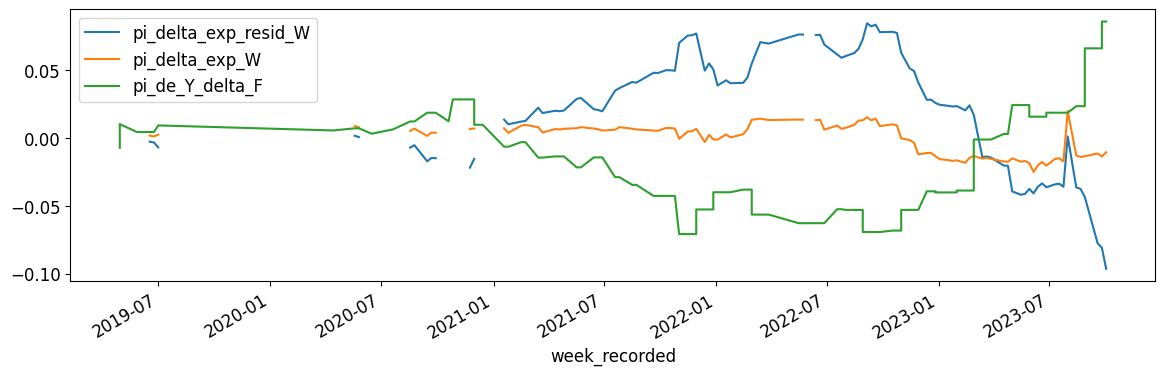

In [17]:
data.set_index('week_recorded')[['pi_delta_exp_resid_W', 'pi_delta_exp_W', 'pi_de_Y_delta_F',]].drop_duplicates().plot()

## expenditure variables

In [18]:
# get changes in expenditure

In [19]:
sub = data.set_index(['id', 'week_recorded']).total_expend.unstack()
sub_fill = sub.ffill(axis=1).bfill(axis=1).copy()

In [20]:
data = data.set_index(['id', 'week_recorded']).join(
    ((sub_fill.shift(1, axis=1) / sub_fill).stack()).rename("total_expend_delta"),
    how='left'
).reset_index()

# analysis

In [208]:
# replace all observations <= 4 with NaN
_ = data[~data.riskaversion.isna()].groupby('id')[['pi_exp_resid', 'pi_perc_resid', 'pi_delta_exp_resid']].count()
df_ols = data[~data.riskaversion.isna()].groupby('id')[
    ['pi_exp_resid', 'pi_perc_resid', 'pi_delta_exp_resid']].mean() 
df_ols *= (_ > 4).replace({False: np.nan})

In [209]:
DICT_PARSE_COLS.update(
    {'pi_perc_resid': float, 'savings_planned': 'categoryO', 'pi_delta_exp_resid': float, 'pinc': float, 'uncertainty aversion': 'categoryO'}
)

In [210]:
df_ols = df_ols.join(data.drop(df_ols.columns, axis=1).groupby('id').last())
df_ols = df_ols.rename(columns={'riskaversion': 'uncertainty aversion'})

In [211]:
lst_dep_col = ['pi_delta_exp_resid']
lst_cols_ols_delta_exp_resid = ['pinc', 'is_unempl', 'uncertainty aversion', 'savings_planned',
                                'profession', 'is_homeown', 'is_food_shop',]

df_ols = df_ols[lst_dep_col + lst_cols_ols_delta_exp_resid].dropna()
df_ols['savings_planned'] = df_ols['savings_planned'] * -1
df_ols = pd_df_astype(df_ols, DICT_PARSE_COLS).copy()

In [215]:
sub = get_ols_dummies(df_ols).astype(float)
ols1 = OLS(sub[lst_dep_col], sub.drop(lst_dep_col, axis=1)).fit()

# lst = ["uncertainty aversion",]
sub = get_ols_dummies(df_ols.drop(lst, axis=1)).astype(float)
ols2 = OLS(sub[lst_dep_col], sub.drop(lst_dep_col, axis=1)).fit()

lst = ["uncertainty aversion", "profession", "savings_planned",]
sub = get_ols_dummies(df_ols[lst_dep_col + lst]).astype(float)
ols3 = OLS(sub[lst_dep_col], sub.drop(lst_dep_col, axis=1)).fit()

lst = ["uncertainty aversion",]
sub = get_ols_dummies(df_ols[lst_dep_col + lst]).astype(float)
ols4 = OLS(sub[lst_dep_col], sub.drop(lst_dep_col, axis=1)).fit()

In [218]:
summary = get_statsmodels_summary([ols3, ols4, ols2, ols1, ], is_filt_sig=False, seperator=" ")
summary.to_csv(os.path.join(GRAPHS_DIR, 'proposal_tab.csv'))
summary

,pi_delta_exp_resid,pi_delta_exp_resid_1,pi_delta_exp_resid_2,pi_delta_exp_resid_3
profession_8.0,0.009 [1.537],NaN,0.015 *** [2.829],0.009 [1.595]
uncertainty aversion_7.0,0.01 *** [2.775],0.014 *** [9.09],NaN,0.019 *** [3.828]
uncertainty aversion_6.0,0.01 *** [2.828],0.015 *** [7.574],NaN,0.019 *** [3.847]
uncertainty aversion_5.0,0.014 *** [3.813],0.019 *** [10.113],NaN,0.024 *** [4.671]
uncertainty aversion_4.0,0.007 * [1.806],0.011 *** [5.048],NaN,0.016 *** [3.108]
uncertainty aversion_3.0,0.009 ** [2.236],0.014 *** [5.787],NaN,0.019 *** [3.563]
uncertainty aversion_2.0,0.008 [1.383],0.013 *** [2.814],NaN,0.018 *** [2.693]
uncertainty aversion_10.0,0.014 *** [2.872],0.019 *** [4.901],NaN,0.022 *** [3.716]
uncertainty aversion_1.0,0.003 [0.239],0.006 [0.502],NaN,0.014 [1.171]
savings_planned_1.0,0.006 ** [1.992],NaN,0.01 *** [3.368],0.006 * [1.92]


In [191]:
ser = data[['id', 'riskaversion', 'savings_planned']].copy().drop_duplicates().dropna().drop('id', axis=1)
ser['riskaversion'] = ser.riskaversion.astype(int)
ser['savings_planned'] = ser.savings_planned * -1

_dict = DICT_PARSE_COLS.copy()
_dict.update(savings_planned=float)

sub = get_ols_dummies(pd_df_astype(ser, _dict).dropna(), ).copy()

ols = OLS(sub.savings_planned, sub.drop('savings_planned', axis=1)).fit()

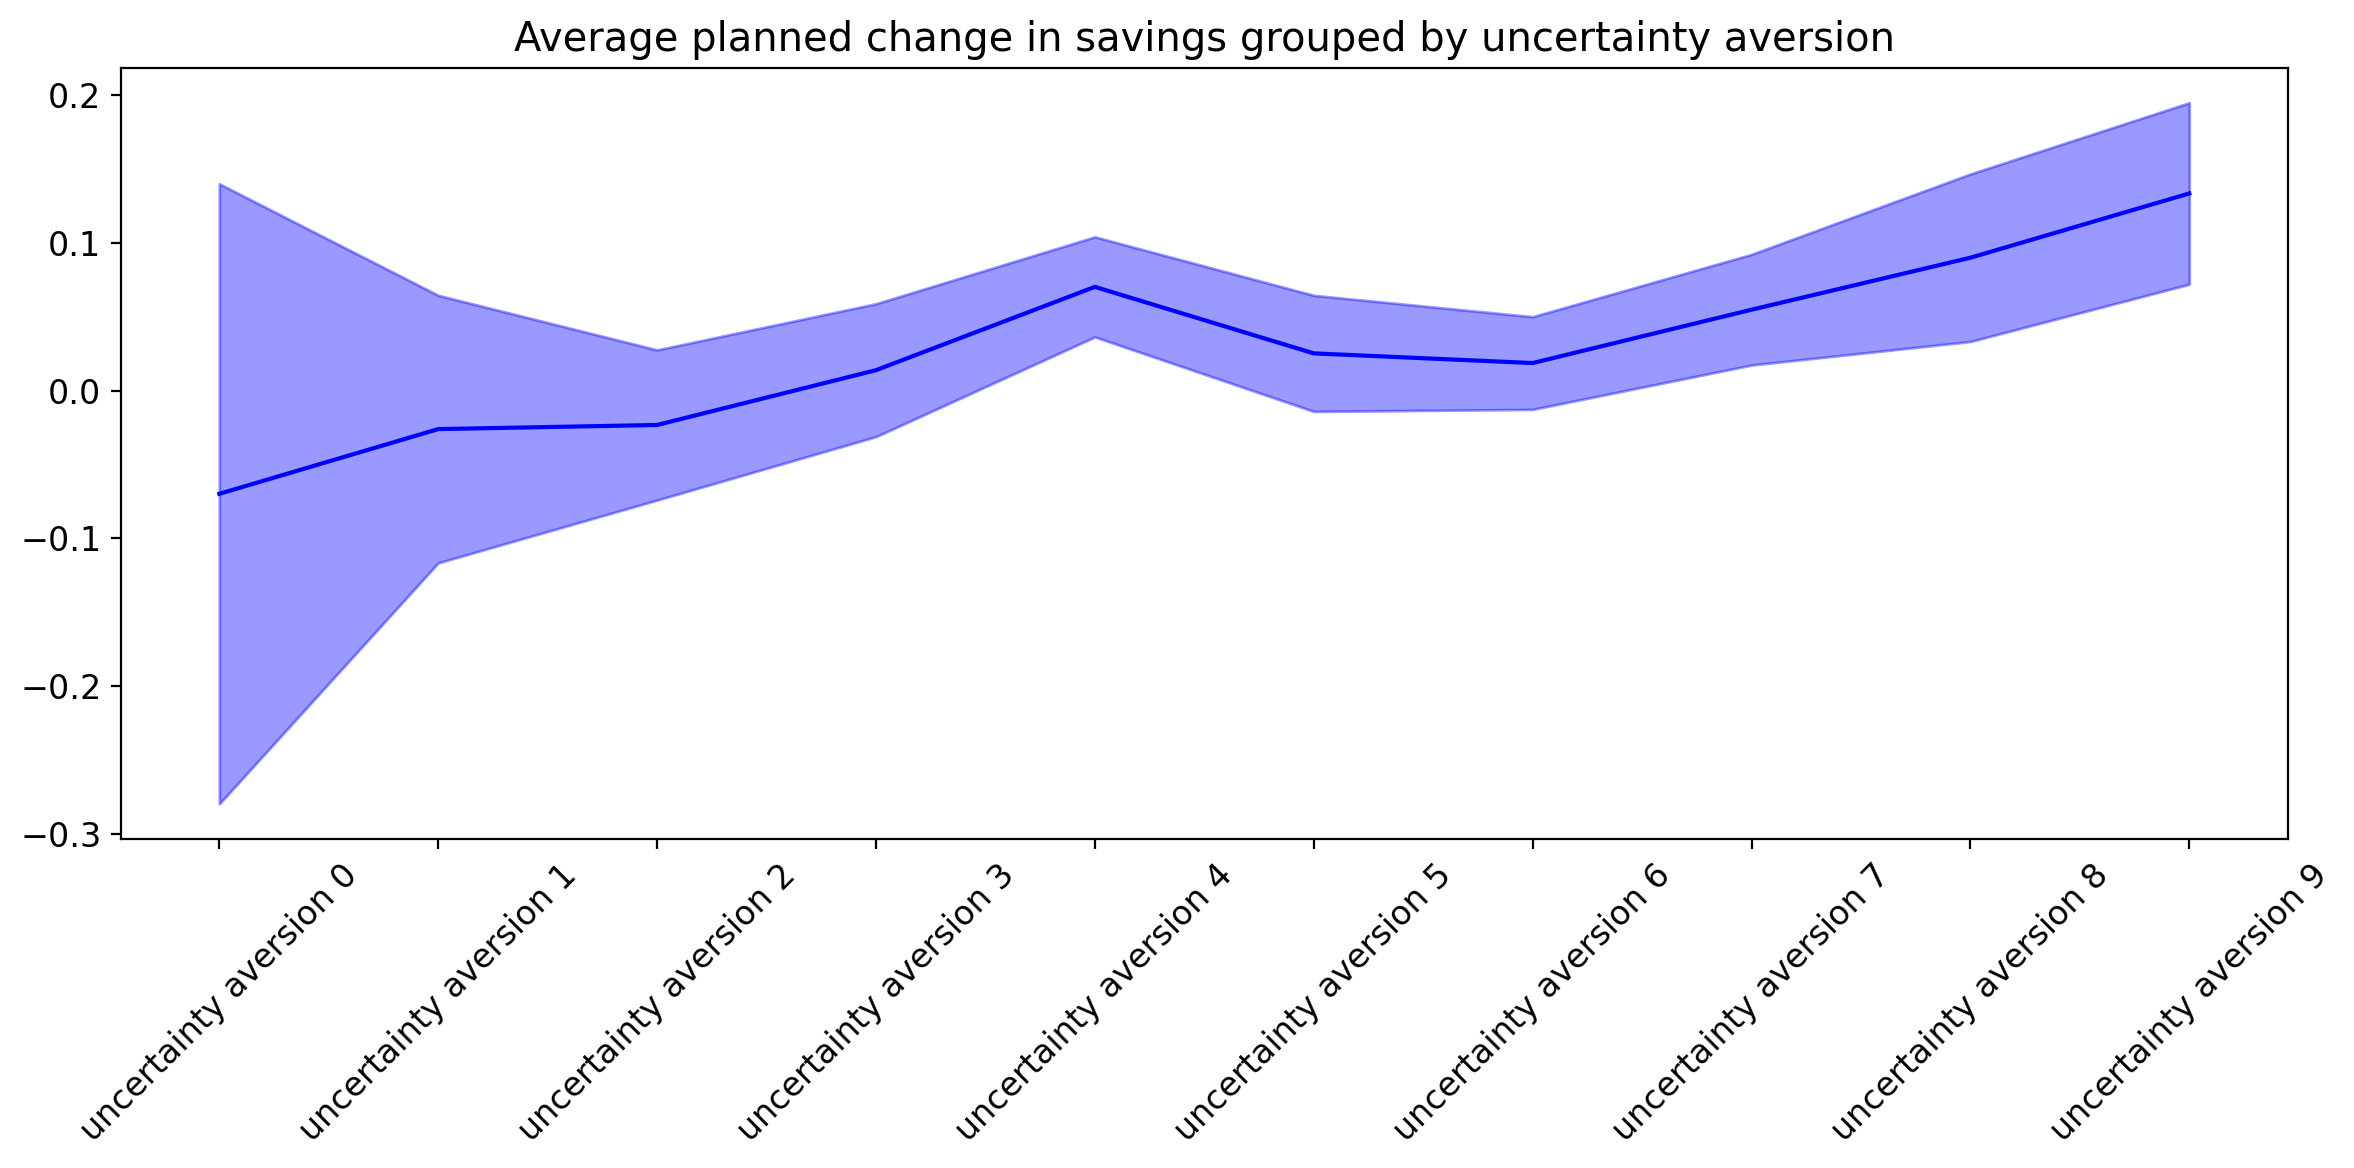

In [192]:
lst_index = [f'uncertainty aversion {i}' for i in range(len(sub.columns[1:]))]
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=200)
ax.tick_params(axis='x', labelrotation=45)

ax.plot(lst_index, ols.params.values, color='blue', label='mean')
ax.fill_between(lst_index, ols.conf_int().iloc[:,0], ols.conf_int().iloc[:,1], color='blue', alpha=.4, label='95% conf.')
ax.set_title("Average planned change in savings grouped by uncertainty aversion")

fig.tight_layout()
fig.savefig(os.path.join(GRAPHS_DIR, 'proposal_fig.png'))

<BarContainer object of 17 artists>

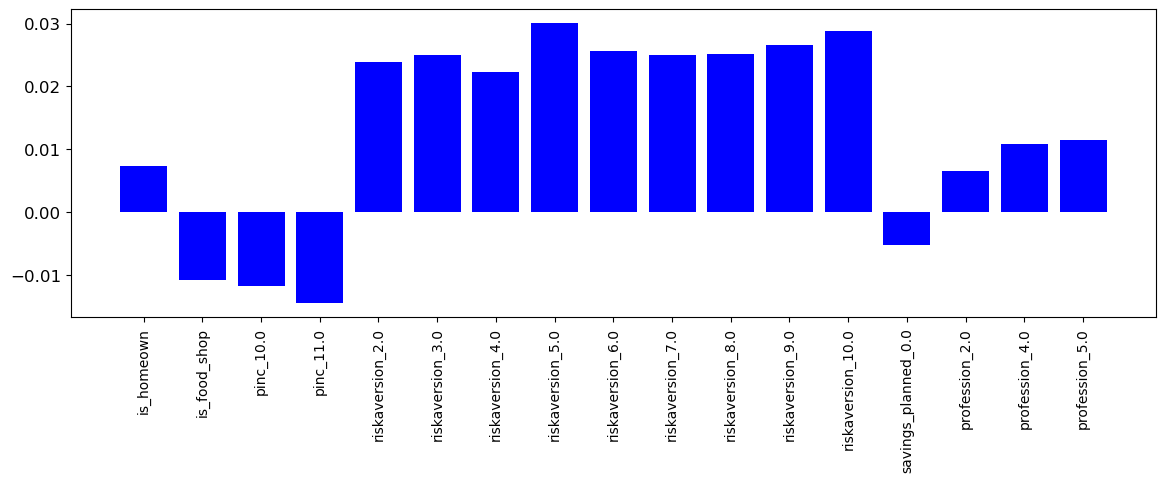

In [27]:
_ = ols.params[ols.pvalues <= .05]
plt.tick_params(axis='x', labelrotation=90, labelsize=10)
plt.bar(_.index, _, color='blue')

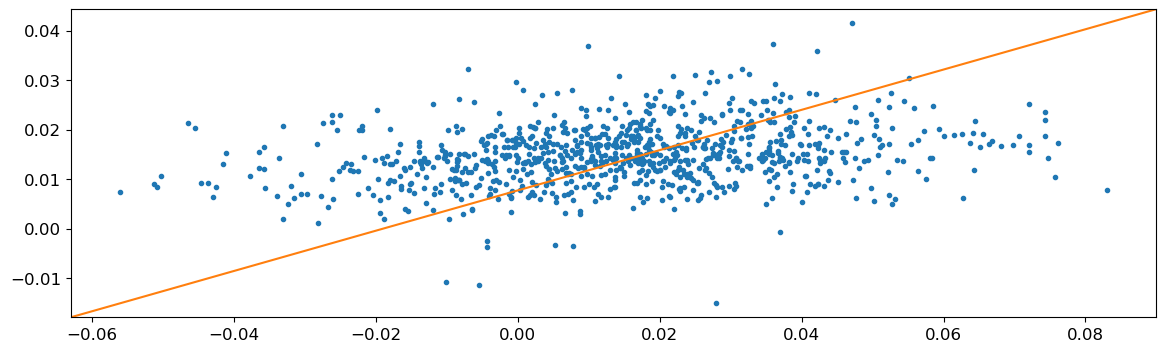

In [28]:
fig, ax = plt.subplots()
ax.plot(sub[lst_dep_col], ols.predict(sub.drop(lst_dep_col, axis=1)), lw=0, marker='.')
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
# plt.plot(

### pymc

In [29]:
# sub = get_ols_dummies(
sub = (
    df_ols[
        ['pi_delta_exp_resid', 'riskaversion']
    ]
).astype(float).copy()
sub = pd_df_astype(sub)

In [101]:
# simulate data

In [93]:
arr_riskaversion_id = np.random.randint(0, 10, 200)
arr_riskaversion_cat = np.array(list(set(arr_riskaversion_id)))
coords = {'riskaversion': arr_riskaversion_cat}

arr_true_deltas = np.concatenate([np.linspace(0, .6, 8), np.array([.2, .2])])
float_true_beta = .8
float_true_sigma = .1
float_true_alpha = .2
dict_true_deltas = dict(zip(arr_riskaversion_cat, arr_true_deltas))

arr_y_true = np.vectorize(dict_true_deltas.__getitem__)(arr_riskaversion_id) * float_true_beta
arr_y_obs = float_true_alpha + arr_y_true + scipy.stats.norm(0, float_true_sigma).rvs(200)

In [110]:
arr_riskaverion_id, arr_riskaversion_cat = sub.riskaversion.factorize()
arr_riskaversion_cat = np.sort(np.array(arr_riskaversion_cat))
arr_y_obs = sub.pi_delta_exp_resid.values

coords = {'riskaversion': arr_riskaversion_cat}
# arr_y_obs

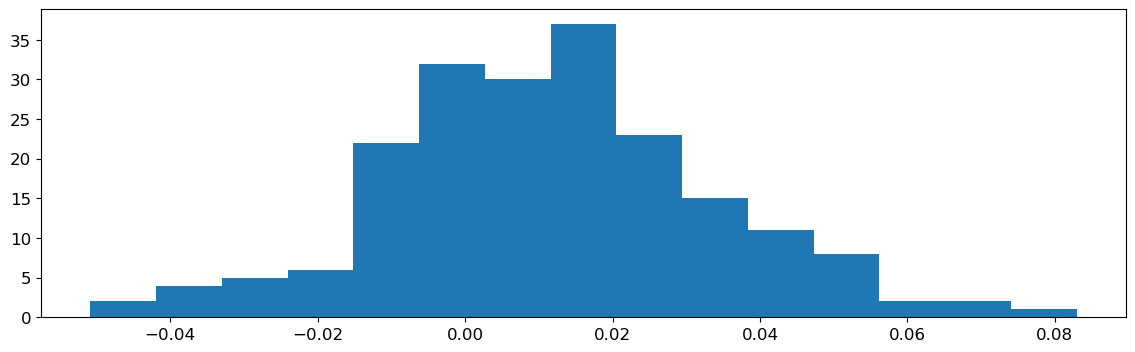

In [105]:
plt.hist(arr_y_obs, bins='fd');
# plt.hist(arr_y_true, bins='fd', alpha=.5);

In [96]:
with pm.Model(coords=coords) as mod_cat1:

    riskaversion = pm.MutableData('riskaversion', arr_riskaverion_id)
    
    alpha = pm.Normal('alpha', 0, .25)
    beta = pm.Normal("beta", 0, 0.5, )
    sigma = pm.Exponential('sigma', .25)
    
    delta_dirichlet = pm.Dirichlet("delta", np.ones(len(arr_riskaversion_cat)-1) * 2)
    delta_0 = [0.0]
    delta_risk = pm.Deterministic('delta_risk', pm.math.concatenate([delta_0, delta_dirichlet]), dims='riskaversion')
    cumulative_delta_risk = delta_risk.cumsum()
    
    mu = alpha + beta * cumulative_delta_risk[riskaversion]
    
    pm.Normal('y', mu=mu, sigma=sigma, observed=arr_y_obs)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(nuts_sampler='numpyro')
    post = pm.sample_posterior_predictive(trace)

Sampling: [alpha, beta, delta, sigma, y]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y]


In [97]:
az.summary(trace, var_names=['alpha', 'beta', 'sigma', 'delta_risk'])

C:\Users\LukasGrahl\miniforge3\envs\pymc_env2\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.420,0.023,0.376,0.464,0.000,0.000,3351.0,2802.0,1.0
beta,-0.037,0.057,-0.145,0.070,0.001,0.001,3405.0,2816.0,1.0
sigma,0.184,0.009,0.168,0.202,0.000,0.000,6460.0,2991.0,1.0
delta_risk[0],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
delta_risk[1],0.120,0.077,0.008,0.264,0.001,0.001,4105.0,2466.0,1.0
delta_risk[2],0.117,0.074,0.005,0.254,0.001,0.001,4610.0,2403.0,1.0
delta_risk[3],0.108,0.071,0.005,0.237,0.001,0.001,4511.0,2423.0,1.0
delta_risk[4],0.109,0.070,0.005,0.238,0.001,0.001,4613.0,2105.0,1.0
delta_risk[5],0.106,0.070,0.006,0.233,0.001,0.001,4658.0,2093.0,1.0
delta_risk[6],0.106,0.071,0.007,0.236,0.001,0.001,5203.0,2423.0,1.0


In [76]:
with mod_cat1:
    # do-operator
    pm.set_data({"riskaversion": (np.ones(200) * 6).astype(int)}) #, "time": time_post, "temp": temp_post})
    # sample from this out of sample posterior predictive distribution
    counterfactual = pm.sample_posterior_predictive(trace, var_names=["y"])

Sampling: [y]


In [111]:
## mod2 

In [33]:
arr_riskaversion_id, arr_riskaversion_cat = sub.riskaversion.factorize()
arr_riskaversion_cat = np.sort(np.array(arr_riskaversion_cat))
arr_y_obs = sub.pi_delta_exp_resid.values

coords = {'riskaversion': arr_riskaversion_cat}
# arr_y_obs

In [34]:
with pm.Model(coords=coords) as mod_stratified:

    RISKAVERS = pm.MutableData('riskaversion', arr_riskaversion_id,)
    
    alpha = pm.Normal('alpha', 0, .25,)
    beta = pm.Normal("beta", 0, 0.5, dims='riskaversion')
    sigma = pm.Exponential('sigma', .25)
    
    mu = alpha + beta[RISKAVERS] 
    
    pm.Normal('y', mu=mu, sigma=sigma, observed=arr_y_obs, )
    
    # prior = pm.sample_prior_predictive()
    trace = pm.sample(nuts_sampler='numpyro')
    # post = pm.sample_posterior_predictive(trace)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.016,0.138,-0.219,0.280,0.011,0.008,173.0,285.0,1.02
beta[-0.0],0.003,0.138,-0.260,0.240,0.011,0.008,173.0,294.0,1.02
beta[1.0],-0.005,0.138,-0.266,0.233,0.011,0.008,173.0,283.0,1.02
beta[2.0],-0.001,0.138,-0.263,0.236,0.011,0.008,173.0,287.0,1.02
beta[3.0],-0.002,0.138,-0.268,0.232,0.011,0.008,174.0,282.0,1.02
beta[4.0],-0.001,0.138,-0.262,0.237,0.011,0.008,174.0,283.0,1.02
beta[5.0],-0.010,0.139,-0.267,0.235,0.011,0.007,176.0,294.0,1.02
beta[6.0],-0.002,0.138,-0.264,0.235,0.011,0.008,174.0,288.0,1.02
beta[7.0],0.003,0.138,-0.252,0.247,0.011,0.007,175.0,303.0,1.02
beta[8.0],-0.003,0.138,-0.260,0.238,0.011,0.008,174.0,298.0,1.02


''

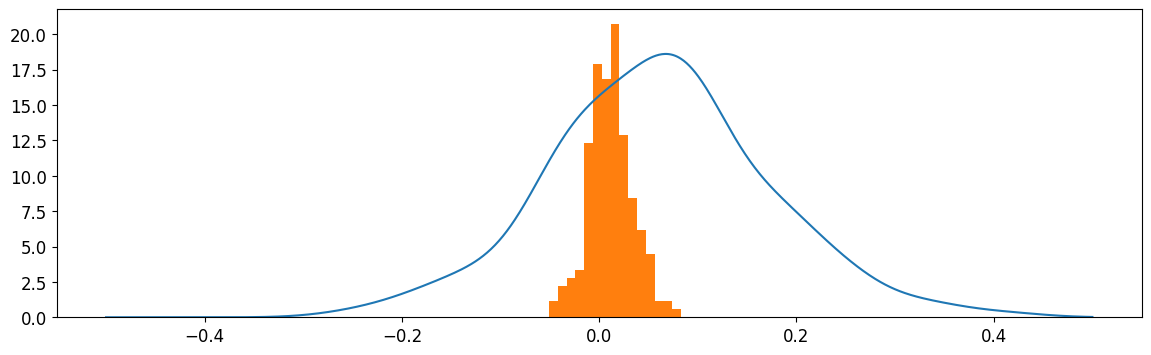

In [54]:
kde = scipy.stats.gaussian_kde(sub.pi_delta_exp_resid)
plt.plot(np.linspace(-.5, .5, 1000), kde.evaluate(np.linspace(-.1, .1, 1000)),)
plt.hist(sub.pi_delta_exp_resid, bins='fd', density=True)
;

In [55]:
### model

In [61]:
arr_riskaverion_id, arr_riskaversion_cat = sub.riskaversion.factorize()
arr_riskaversion_cat = np.sort(np.array(arr_riskaversion_cat))
arr_delta_exp_resid = sub.pi_delta_exp_resid.values

coords = {'riskaversion': arr_riskaversion_cat}

In [62]:
arr_riskaversion_cat.shape

(10,)

In [65]:
with pm.Model(coords=coords) as mod_cross:
    id_riskaversion = pm.MutableData('riskaversion', arr_riskaverion_id)
    
    delta_dirichlet = pm.Dirichlet(
        'delta',
        np.repeat(0.0, coords['riskaversion'].shape[0]-1), 
        shape=(coords['riskaversion'].shape[0]-1,)
    )
    delta_risk = pm.Deterministic('delta_risk', pt.concatenate([pt.zeros(1), delta]), dims='riskaversion')
    delta_risk_cum = pt.cumsum(delta_risk)
    
    beta = pm.Normal('beta', 0, 1, )
    sigma = pm.Exponential('sigma', 1)
    
    mu = beta * delta_risk_cum[arr_riskaverion_id]
    
    pm.Normal("y", mu=mu, sigma=sigma, observed=arr_delta_exp_resid)


In [ ]:
with mod_cross:
    # prior_cross = pm.sample_prior_predictive()
    trace_cross = pm.sample(nuts_sampler='numpyro')
    # post_cross = pm.sample_posterior_predictive(trace_cross)

Sampling: [beta, delta, sigma, y]


In [ ]:
az.plot(prior_cross, group='prior')

In [34]:
with pm.Model() as mod_categorical:
    R = pm.MutableData('riskaversion', sub.riskaversion.factorize()[0])
    
    delta = pm.Dirichlet('delta',np.repeat(0.0, 10), shape=10)
    delta_j = pt.concatenate([pt.zeros(1), delta])
    delta_j_cum = pt.cumsum(delta_j)
    
    b_R = pm.Normal('b_risk', 0, 1, shape=1)
    
    y_hat = b_R * delta_j_cum[R]
    
    lkh = pm.Normal('y', mu=y_hat, sigma=.5, observed=sub[lst_dep_col].values[:,0])

In [ ]:
with mod_categorical:
    prior = pm.sample_prior_predictive()
    idata = pm.sample(nuts_sampler="numpyro")

Sampling: [b_risk, delta, y]


In [ ]:
az.plot_ppc(prior, data_pairs={"y":"y",}, group='prior')

In [79]:
with pm.Model() as mod:
    alpha = pm.Normal('alpha', 0, 5)
    betas = pm.Normal('betas', 0, 2, shape=(sub.shape[1]-1,1))
    sigma = pm.HalfNormal('sigma', 2, )
    mu = pm.Deterministic('mu', alpha + X @ betas)
    
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    
    prior = pm.sample_prior_predictive()

Sampling: [alpha, betas, sigma, y]


ValueError: Shape mismatch: A.shape[1] != x.shape[0]
Apply node that caused the error: CGemv{inplace}(AllocEmpty{dtype='float64'}.0, 1.0, [[0. 1. 1. ... 0. 0. 0.]], DropDims{axis=1}.0, 0.0)
Toposort index: 6
Inputs types: [TensorType(float64, shape=(923,)), TensorType(float64, shape=()), TensorType(float64, shape=(923, 32)), TensorType(float64, shape=(10,)), TensorType(float64, shape=())]
Inputs shapes: [(923,), (), (923, 32), (10,), ()]
Inputs strides: [(8,), (), (8, 7384), (8,), ()]
Inputs values: ['not shown', array(1.), 'not shown', 'not shown', array(0.)]
Outputs clients: [[ExpandDims{axis=1}(CGemv{inplace}.0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

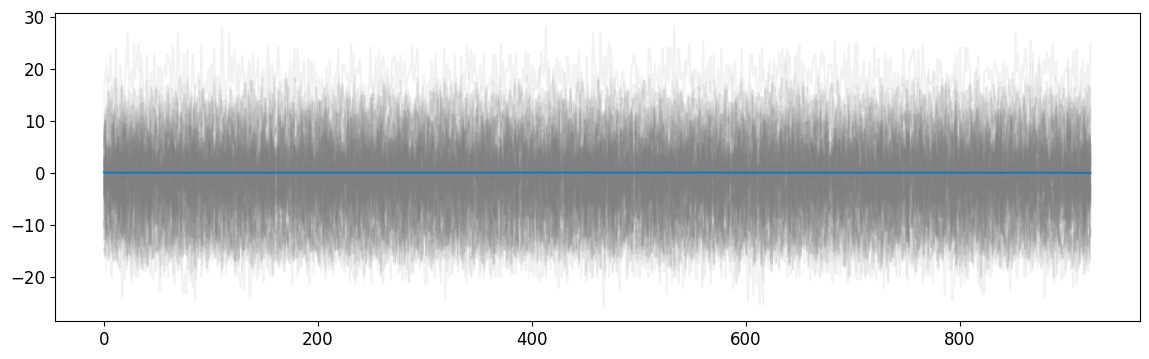

In [144]:
# prior
plt.plot(get_idata_sample(prior, 'mu', 'prior')[:,:,0].T, alpha=.1, color='grey');
plt.plot(y)

In [145]:
with mod:
    idata = pm.sample(chains=2, nuts_sampler="numpyro", tune=1500, draws=2000) # idata_kwargs = {'log_likelihood': True})
    post = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:00.927177
Sampling...


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Sampling: [y]


Sampling time =  0:00:08.662293
Transforming variables...
Transformation time =  0:00:00.044361


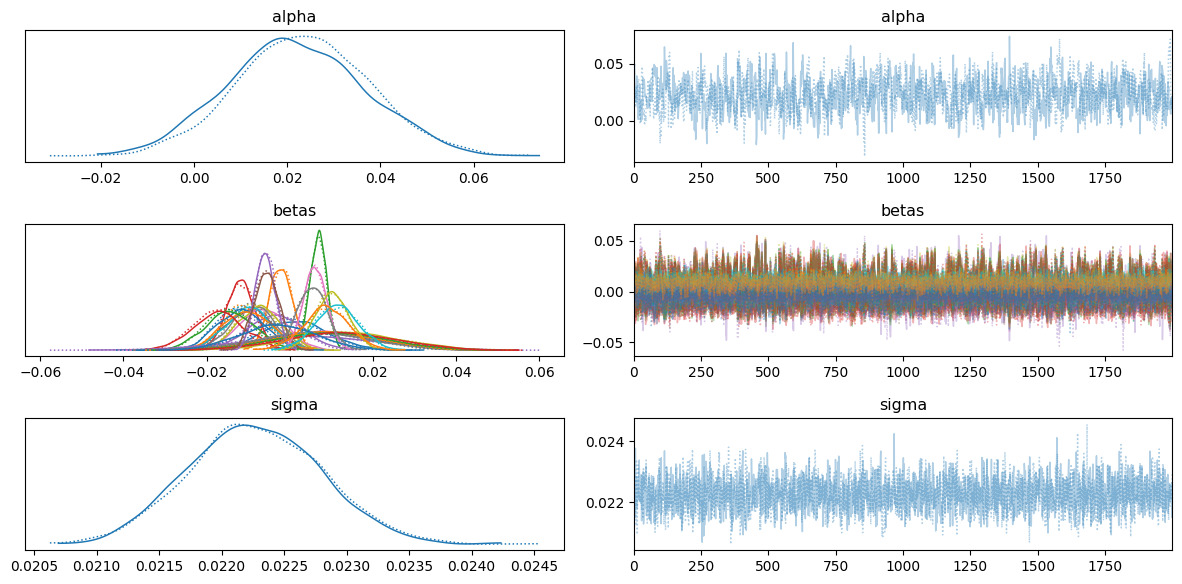

In [146]:
az.plot_trace(idata, var_names=['alpha', 'betas', 'sigma']);
plt.tight_layout()

In [147]:
def get_idata_sample(idata, var_name: str = 'mu', mode: str = 'post', n_samples: int = 100, is_prior_pred: bool = False):
    if mode == 'prior':
        prior = idata.prior
        
        if is_prior_pred:
            prior = idata.prior_predictive[var_name]
        
        # number of data observations
        n_obs = prior[var_name].shape[2:]
        # number of prior samples
        n_draws = len(prior.draw)
        
        # number of samples to draw from posterior
        n_samples = min(n_samples, 1 * n_draws)

        samp = prior[var_name].values[:, get_samp(n_draws, n_samples),:].reshape(1*n_samples, *n_obs)

        return samp
    
    if mode == 'post':
        # number of chains
        n_chains = len(idata.sample_stats.chain)
        # number of draws in a chain
        n_draws = len(idata.sample_stats.draw)

        post = idata.posterior
        # number of data observations
        n_obs = post[var_name].shape[2:]

        # number of samples to draw from posterior
        n_samples = min(n_samples, n_chains * n_draws)

        samp = post[var_name].values[:, get_samp(n_draws, n_samples),:].reshape(n_chains*n_samples, *n_obs)

        return samp

In [148]:
from src.pymc_modelling import get_pymc_mod_table, get_post_sample

In [149]:
def get_pymc_mod_table(idata, lst_params=None, param_names: list = None, n_round: int = 2, seperator: str = "\n", conf_int_perc: int = .05):
    """
    Prints PYMC model summary table
    :param idata:
    :param lst_params:
    :param n_round:
    :param seperator:
    :return:
    """
    # assert 'log_likelihood' in list(idata.keys()), "pls add idata_kwargs = {'log_likelihood': True}) to pm.sample"

    dict_params, dict_information = {}, {}
    n_chains = len(idata.sample_stats.chain)
    n_draws = len(idata.sample_stats.draw)
    post = idata.posterior

    if lst_params is None:
        lst_params = list(idata.posterior.data_vars.keys())

    for param in lst_params:

        shape_param = post[param].values.shape[2:]
        if len(shape_param) == 0:
            shape_param = (1,1)
        assert len(shape_param) <= 2, "param dimension > 2 not supported"

        arr_param_est = post[param].values.reshape(*shape_param, n_chains * n_draws)
        
        for idx in range(shape_param[0]):
            _dict = {}
            _dict['mean'] = arr_param_est[idx].mean(axis=-1)[0]
            _dict['std'] = arr_param_est[idx].std(axis=-1)[0]
            _dict['confu'] = np.percentile(arr_param_est[idx], 100-conf_int_perc*100/2, axis=1)[0]
            _dict['confl'] = np.percentile(arr_param_est[idx], conf_int_perc*100/2, axis=1)[0]

            dict_params[f'{param}_{idx}'] = _dict
    
    if param_names is not None:
        # print(len(dict_params))
        dict_params = {param_names[i]: v for i, v in enumerate(list(dict_params.values()))}

    dict_information['N chains'] = n_chains
    dict_information['N draws'] = n_draws
    dict_information['N'] = len(idata.observed_data[list(idata.observed_data.data_vars.keys())[0]])
    # dict_information['LOO'] = az.loo(idata).p_loo
    # dict_information['WAIC'] = az.waic(idata).p_waic
    dict_information['MCMC divergence'] = idata.sample_stats.diverging.sum().values

    # return dict_params

    df_params = pd.DataFrame(dict_params).T

    dict_information = {key: dict_information for key in df_params.columns}
    df_info = pd.DataFrame(dict_information)

    df = pd.concat(
        [
            pd.DataFrame(dict_params).T,
            pd.DataFrame(dict_information),

        ],
        axis=0,
    ).astype(float)

    df['print'] = df['mean'].round(n_round).astype(str) + seperator + "[" + df['confl'].round(n_round).astype(str) \
                  + "," + df['confu'].round(n_round).astype(str) + "]"

    return df

<AxesSubplot: xlabel='y / y'>

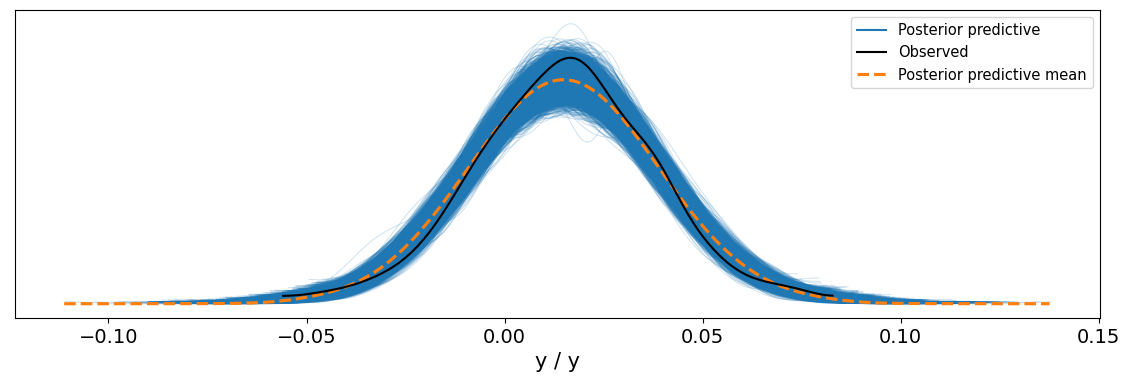

In [150]:
az.plot_ppc(post,  data_pairs={"y":"y"}) #, var_names=['mu'])

In [151]:
summary = get_pymc_mod_table(idata, ['alpha', 'betas'], param_names=['const'] + list(sub.columns[1:]), conf_int_perc=.1)

<BarContainer object of 33 artists>

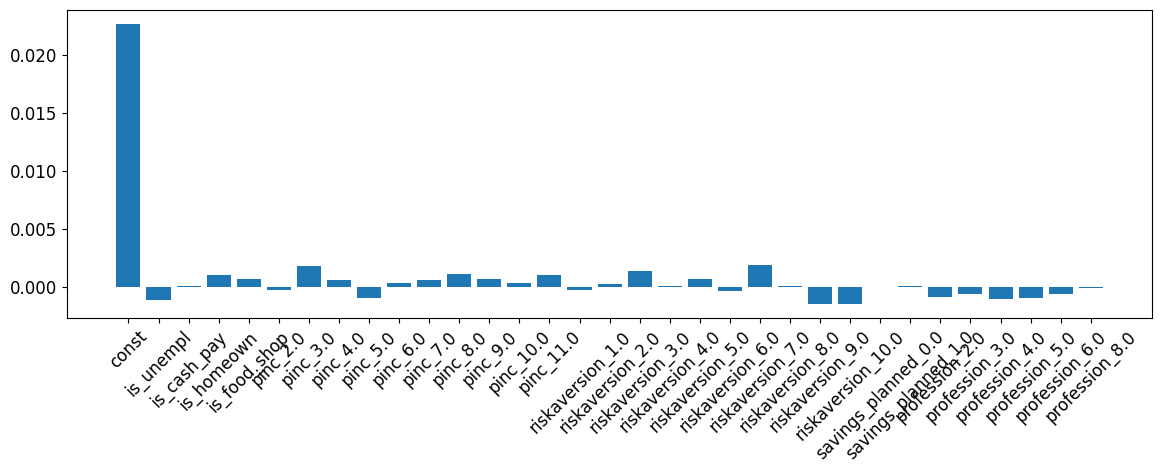

In [153]:
plt.tick_params(axis='x', rotation=45)
plt.bar(summary.iloc[:-4].index, summary.iloc[:-4]['mean'])

In [206]:
# merge results

In [207]:
ser_coefs = ols.params * (ols.pvalues <= .05)

In [208]:
df_ols['pi_delta_exp_resid_hat'] = df_ols.iloc[:,1:] @ ser_coefs

In [209]:
sub = data.set_index('id').join(df_ols.pi_delta_exp_resid_hat).reset_index().copy()

In [210]:
sub = sub.set_index('week_recorded').join(sub.groupby('week_recorded').pi_delta_exp_resid_hat.mean().rename('pi_delta_exp_resid_hat_W'))
sub = sub.reset_index()

In [211]:
sub = sub.set_index('week_recorded')[
    ['pi_delta_exp_resid_W', 'pi_delta_exp_W', 'pi_de_Y_delta_F', 'pi_delta_exp_resid_hat_W']
    # ['pi_delta_exp_resid_W', 'pi_delta_exp_resid_hat_W', 'pi_delta_exp_W']
].fillna(0).copy()

In [212]:
sub['pi_delta_exp_resid_W_resid'] = sub.pi_delta_exp_resid_W - sub.pi_delta_exp_resid_hat_W

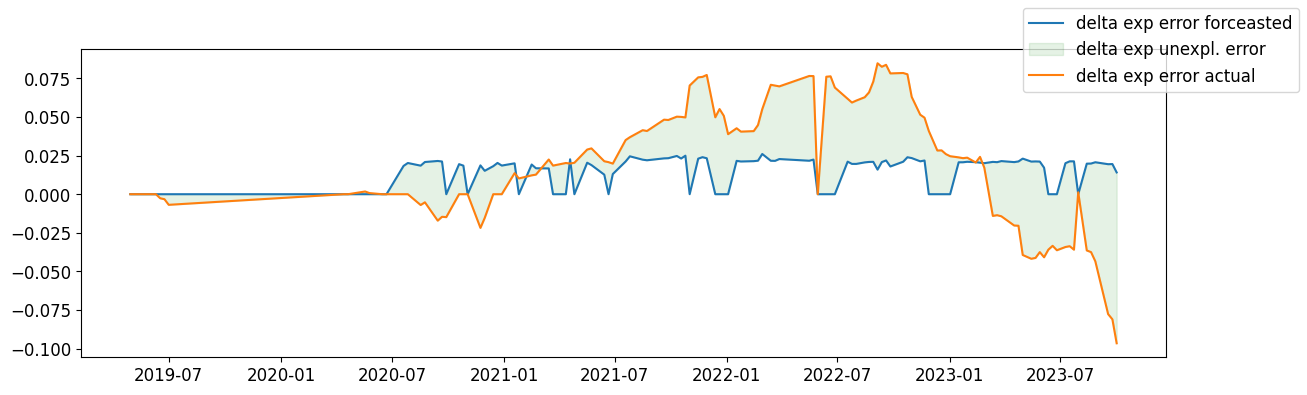

In [213]:
fig, ax = plt.subplots()
ax.plot(sub.pi_delta_exp_resid_hat_W, label='delta exp error forceasted')
ax.fill_between(sub.index, sub.pi_delta_exp_resid_W, sub.pi_delta_exp_resid_hat_W, 
                color='green', alpha=.1, label='delta exp unexpl. error')
ax.plot(sub.pi_delta_exp_resid_W, label='delta exp error actual')
# ax.plot(sub.pi_de_Y_delta_F, label='$\pi^{\Delta}_{t+12}$')

fig.legend()

In [41]:
# riskaversion and savings

In [147]:
df_similarity = data.groupby('id')[
    ['riskaversion', 'savings_expend_frac', 'savings_expend', 'savings_planned', 'pinc', 'hhinc',
     'is_unempl', 'profession', 'is_cash_pay', 'is_homeown', 'hhchildren', 'durables_planned_expend']
].last()

In [148]:
DICT_PARSE_COLS.update({'riskaversion': float, 'savings_expend_frac': float, 'savings_planned': 'category'})
df_similarity = pd_df_astype(df_similarity, DICT_PARSE_COLS)

In [149]:
lst_dep_var = ['riskaversion']
lst_cols_risaversion = ['hhinc', 'pinc', 'savings_planned', 'durables_planned_expend', 'profession']
df_similarity = df_similarity[lst_dep_var + lst_cols_risaversion].dropna()

In [150]:
df_similarity = get_ols_dummies(df_similarity).astype(float)
df_similarity.shape

(2184, 33)

In [151]:
mask = np.ones((df_similarity.shape[1]-1, df_similarity.shape[1]-1))
mask[np.diag_indices(mask.shape[0])] = np.ones(mask.shape[0]) * np.nan

<AxesSubplot: >

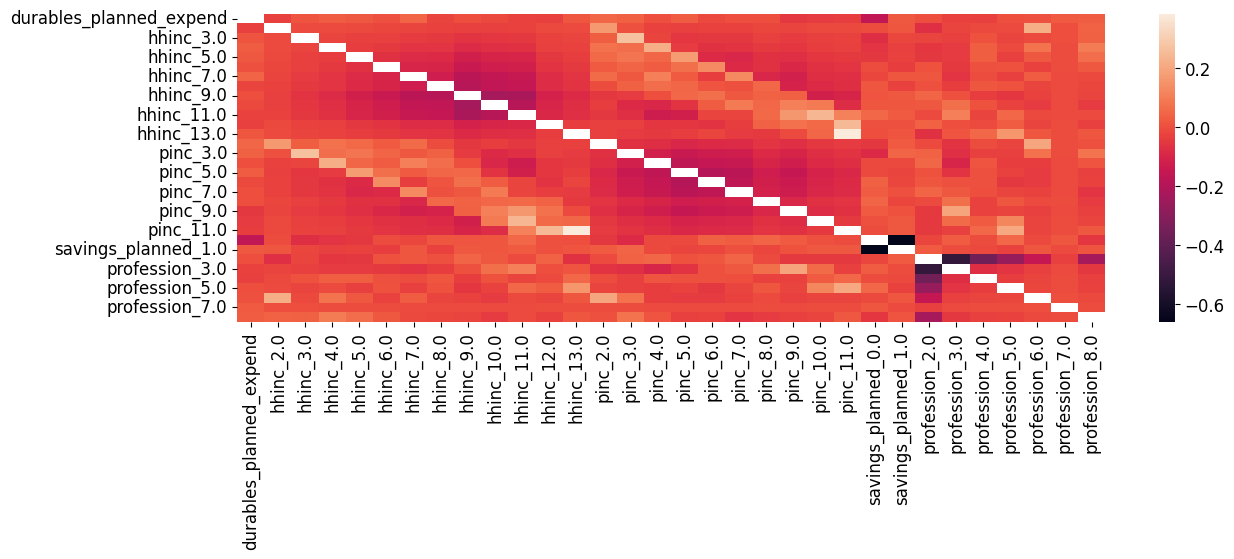

In [154]:
sns.heatmap(df_similarity.drop(lst_dep_var, axis=1).corr() * mask)

In [155]:
ols = OLS(df_similarity[lst_dep_var], df_similarity.drop(lst_dep_var, axis=1)).fit()

In [158]:
summary = get_statsmodels_summary([ols], is_filt_sig=False)
# summary

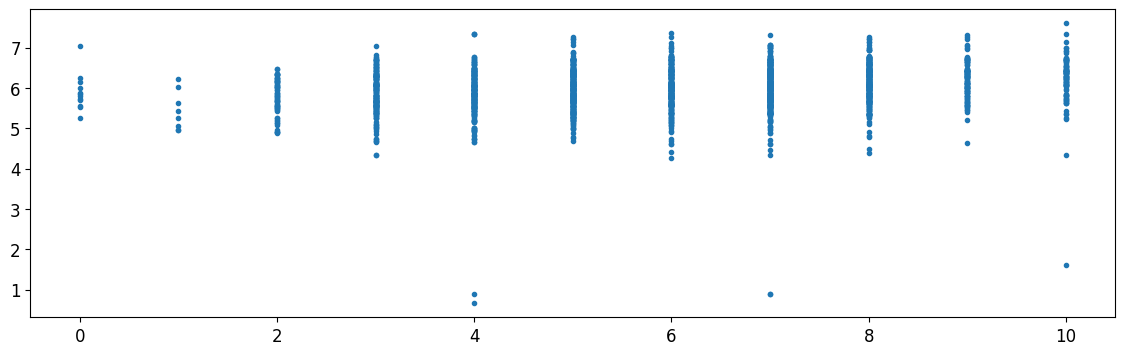

In [159]:
plt.plot(
    df_similarity[lst_dep_var], ols.predict(df_similarity.drop(lst_dep_var, axis=1)),
    lw=0, marker='.'
)

In [160]:
riskaversion_hat = get_ols_dummies(get_ols_dummies(pd_df_astype(data[lst_cols_risaversion].dropna()))).astype(float) \
                    @ (ols.params * (ols.pvalues <= .05))
riskaversion_hat = riskaversion_hat.rename('riskaversion_hat')
data = data.join(riskaversion_hat)

In [165]:
_ = [i for i in lst_cols_ols_delta_exp_resid if i not in ['riskaversion']]
_ += ['riskaversion_hat']
sub = data[_].dropna().copy().rename(columns={'riskaversion_hat': 'riskaversion'})
sub['riskaversion'] = sub.riskaversion.round()
DICT_PARSE_COLS.update({'riskaversion': 'categoryO'})
sub = pd_df_astype(sub[lst_cols_ols_delta_exp_resid], DICT_PARSE_COLS)

In [166]:
sub = get_ols_dummies(sub, drop_first=False)

In [167]:
sub['pi_delta_exp_resid_hat2'] = sub[[i for i in sub.columns if i in ser_coefs.index]] \
                                @ ser_coefs.loc[[i for i in sub.columns if i in ser_coefs.index]]

In [168]:
data = data.join(sub.pi_delta_exp_resid_hat2)

<AxesSubplot: xlabel='week_recorded'>

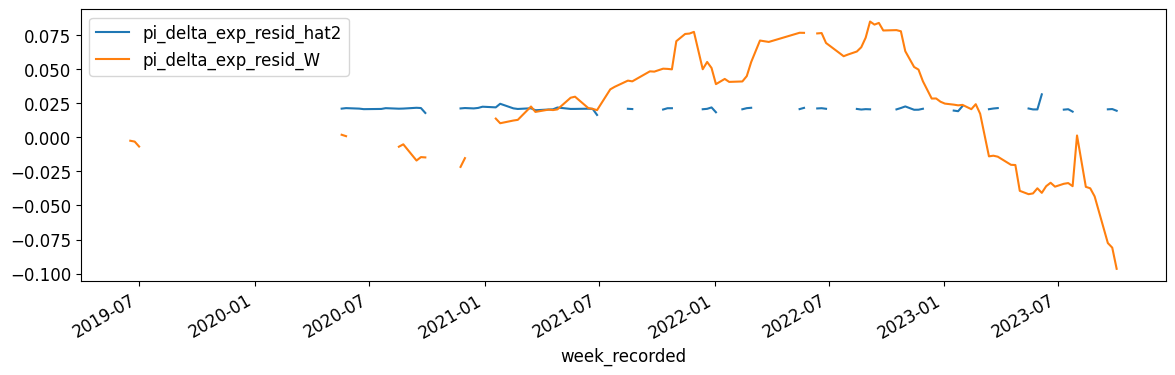

In [169]:
data.groupby('week_recorded')[['pi_delta_exp_resid_hat2', 'pi_delta_exp_resid_W']].mean().plot()

In [ ]:
# analyse savings and risk aversion

In [ ]:
sub